# Conv1D + LSTM + DNN on Time Series Australia Minimum Temperature:


Coursera Colab Link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Exercise%20Question.ipynb

Answers Coursera Colab Link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Exercise%20Answer.ipynb

ML Mastery: https://machinelearningmastery.com/

Jason Brownlee datasets: https://github.com/jbrownlee/Datasets


LSTM Andrew Ng:  https://www.coursera.org/lecture/nlp-sequence-models/long-short-term-memory-lstm-KXoay

- We add a Convolution 1D layer at the beginning.
- RNN expects a 3D dataset: [batch size, window of time steps, variate value]. In our case we only have one variable so it is [batch_size, window_size, 1]
- However, we won't use a Lambda layer to expand the dims but we'll do it in the dataset preparation function. Since our dataset is 2D [batch_size, window_size], we'll have to expand using tf.exapnd_dims.
- RNN only outputs the last sequence (last time step) by default, if we want to get the output for all the sequences (all time steps) to feed it into a lower RNN, we need to use return_sequences=True.
- RNN use 'tanh' as activation function by default.
- Simple RNN use the output as the state vector recurred (fed back) to the next time step.
- LSTM carry a cell state from step 0 to the end time step in order that initial information has bigger impact on latter time steps than on the simple RNN.
- Bidirectional then carries info from 0 to end and then from end to 0.

TF Keras Conv1D: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D

TF Keras LSTM: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

TF Keras DNN: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense


mini-batch gradient descent Andrew Ng: https://www.youtube.com/watch?v=4qJaSmvhxi8

Huber loss function: https://en.wikipedia.org/wiki/Huber_loss

Lambda tf keras layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda

tf.expand_dims: https://www.tensorflow.org/api_docs/python/tf/expand_dims


TF Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

np.newaxis: https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae

Keras Callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv 


2.2.0-rc2


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-04-11 17:57:04--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.009s  

2020-04-11 17:57:04 (7.33 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



In [0]:
# reading the dataset with pandas: 
df = pd.read_csv('/tmp/daily-min-temperatures.csv', sep=',', engine='python')

print(df.head())
print(df.shape)

         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8
(3650, 2)


(3650,)
(3650,)


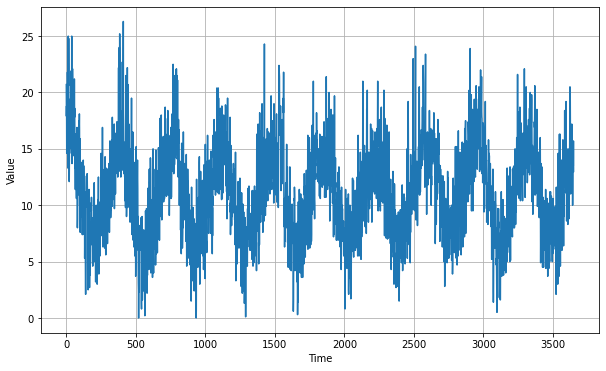

In [0]:
# Defining the Time Series:
time_step = np.arange(df.shape[0])
temps = df['Temp'].values

print(time_step.shape)
print(temps.shape)

series = temps
time = time_step

# Alternative using csv:
# # import csv
# time_step = []
# temps = []

# with open('/tmp/daily-min-temperatures.csv') as csvfile:
# # YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# # HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
#   reader = csv.reader(csvfile, delimiter=',')
#   next(reader)
#   i=0
#   for row in reader:
#     temps.append(float(row[1]))
#     time_step.append(int(i))
#     i+=1
#
# series = np.array(temps)
# time = np.array(time_step)


series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
# Splitting the dataset into training and validation sets:

split_time = 2500
time_train = time[:split_time]  # YOUR CODE HERE
x_train = series[:split_time]  # YOUR CODE HERE
time_valid = time[split_time:]  # YOUR CODE HERE
x_valid = series[split_time:]  # YOUR CODE HERE

window_size = 30
batch_size = 36
shuffle_buffer_size = 1000


In [0]:
# Function to prepare the train set for training:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)  # expanding the series by 1 dim as needed by rnn
    ds = tf.data.Dataset.from_tensor_slices(series)  # creating a tf dataset
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)  # creating windows of time sequences
    ds = ds.flat_map(lambda w : w.batch(window_size+1))  # flattening these windows with the same batch size
    ds = ds.shuffle(shuffle_buffer)  # shuffling the data
    ds = ds.map(lambda w: (w[:-1], w[1:]))  # splitting the series into features and labels
    ds = ds.batch(batch_size).prefetch(1)   # splitting the dataset into batches

    return ds

In [0]:
# Function to forecast:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w : w.batch(window_size))
    ds = ds.batch(32).prefetch(1) 

    return model.predict(ds)

# Conv1D+LSTM+DNN with learning-rate sweep

In [0]:
# Clearing the session
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Preparing the dataset:
window_size = 60
batch_size = 36

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

# Creating the NN model:
model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(36, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
tf.keras.layers.LSTM(60, return_sequences=True),
tf.keras.layers.LSTM(60, return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1), #,
tf.keras.layers.Lambda(lambda x : x * 25.0)
])

model.summary()

# Defining optimizer and loss:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae",'mse','accuracy'])
# model.compile(loss='mse', optimizer=optimizer, metrics=["mae",'mse','accuracy'])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 36)          216       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          23280     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
____________________

In [0]:
# defining the learning rate sweep as a callback:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Training the model:
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
68/68 [==============================] - 1s 10ms/step - loss: 12.1343 - mae: 12.6322 - mse: 177.7998 - accuracy: 8.1967e-04 - lr: 1.0000e-08
Epoch 2/100
68/68 [==============================] - 1s 10ms/step - loss: 12.1026 - mae: 12.6039 - mse: 177.0764 - accuracy: 8.1967e-04 - lr: 1.1220e-08
Epoch 3/100
68/68 [==============================] - 1s 10ms/step - loss: 12.0707 - mae: 12.5715 - mse: 176.2501 - accuracy: 8.1967e-04 - lr: 1.2589e-08
Epoch 4/100
68/68 [==============================] - 1s 10ms/step - loss: 12.0352 - mae: 12.5351 - mse: 175.3233 - accuracy: 8.1967e-04 - lr: 1.4125e-08
Epoch 5/100
68/68 [==============================] - 1s 10ms/step - loss: 11.9919 - mae: 12.4942 - mse: 174.2880 - accuracy: 8.1967e-04 - lr: 1.5849e-08
Epoch 6/100
68/68 [==============================] - 1s 10ms/step - loss: 11.9482 - mae: 12.4483 - mse: 173.1265 - accuracy: 8.1967e-04 - lr: 1.7783e-08
Epoch 7/100
68/68 [==============================] - 1s 10ms/step - loss: 11.8911 

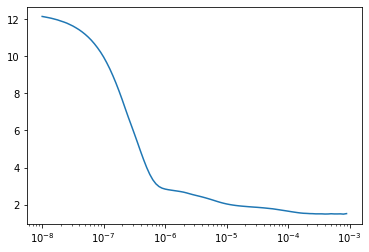

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 60])

# Conv1D+LSTM+DNN with best learning rate

In [0]:
# Clearing the session
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Preparing the dataset:
window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

# Creating the NN model:
model = tf.keras.models.Sequential([
# YOUR CODE HERE
tf.keras.layers.Conv1D(36, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
tf.keras.layers.LSTM(60, return_sequences=True),
tf.keras.layers.LSTM(60, return_sequences=True),
tf.keras.layers.Dense(30, activation='relu'),
tf.keras.layers.Dense(10, activation='relu'),
tf.keras.layers.Dense(1) #,
# tf.keras.layers.Lambda(lambda x : x 25.0)
])

model.summary()

# Defining optimizer and loss:
optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae",'mse','accuracy'])
# model.compile(loss='mse', optimizer=optimizer, metrics=["mae",'mse','accuracy'])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 36)          216       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          23280     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
Total params: 54,687

In [0]:
# Training the model:
history = model.fit(train_set, epochs=100, verbose=1)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
10/10 [==============================] - 0s 19ms/step - loss: 10.3237 - mae: 10.8291 - mse: 133.6528 - accuracy: 8.2102e-04
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 10.0150 - mae: 10.5370 - mse: 127.3457 - accuracy: 8.1460e-04
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 9.6544 - mae: 10.1624 - mse: 119.5067 - accuracy: 1.2187e-04
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 9.0792 - mae: 9.5792 - mse: 107.8754 - accuracy: 3.8485e-05
Epoch 5/100
10/10 [==============================] - 0s 22ms/step - loss: 7.8956 - mae: 8.4335 - mse: 87.0859 - accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 23ms/step - loss: 5.4790 - mae: 6.0380 - mse: 51.3440 - accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 23ms/step - loss: 3.2324 - mae: 3.7018 - mse: 21.9090 - accuracy: 0.0000e+00
Epoch 8/100
10/10 [==============================] - 0s 23ms

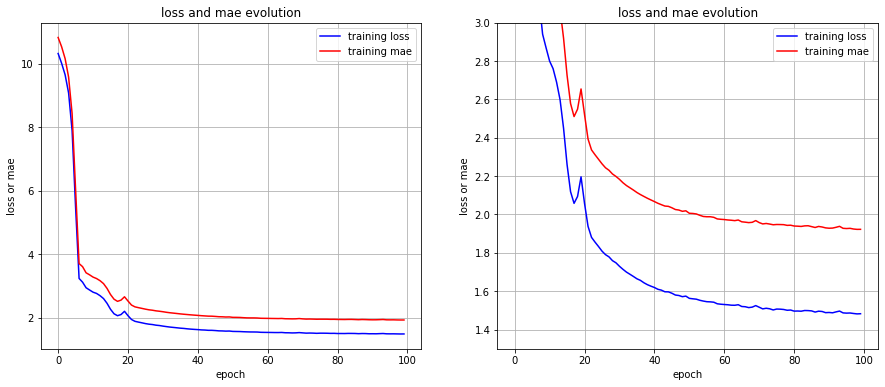

In [0]:
# Plotting the training evolution:

loss = history.history['loss']
mae = history.history['mae']
mse = history.history['mse']

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(loss,'b',label='training loss')
plt.plot(mae,'r',label='training mae')
plt.xlabel('epoch')
plt.ylabel('loss or mae')
plt.legend()
plt.grid()
plt.title('loss and mae evolution')

plt.subplot(1,2,2)
plt.plot(loss,'b',label='training loss')
plt.plot(mae,'r',label='training mae')
plt.xlabel('epoch')
plt.ylabel('loss or mae')
plt.legend()
plt.grid()
plt.title('loss and mae evolution')
plt.ylim(1.3,3)

plt.show()

In [0]:
# Predicting the forecast for the validation set:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

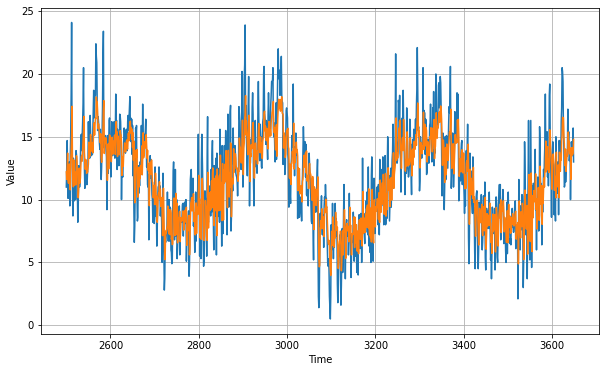

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [0]:
# Keras metrics for the validation set:
print(tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

5.24128
1.7854522


In [0]:
# Forecast for the validation set:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[12.20666  11.608028 12.663583 ... 13.594051 13.684365 14.790057]
